In [ ]:
import pandas as pd 
import statsmodels.api as sm
df_train = pd.read_csv("../DATA/processed/synthetic_sales_expanded.csv")


: 

In [ ]:
print(df_train[['DATE']])
df_train['year'] = pd.to_datetime(df_train['DATE']).dt.year
df_train['month'] = pd.to_datetime(df_train['DATE']).dt.month
df_train['day'] = pd.to_datetime(df_train['DATE']).dt.day

df_train.sample(20)





                DATE
0         2023-01-01
1         2023-01-02
2         2023-01-03
3         2023-01-04
4         2023-01-05
...              ...
15820297  2024-12-27
15820298  2024-12-28
15820299  2024-12-29
15820300  2024-12-30
15820301  2024-12-31

[15820302 rows x 1 columns]


,PRODUTO,DATE,CLASSE TERAPÊUTICA,LABORATÓRIO,TARJA,PMC Sem Imposto,PMC 0%,PMC 12%,PMC 18%,PMC 21%,PMC 22%,QUANTITY_SOLD,UNITARY_PRICE,year,month,day
8014539,NORIPURUM,2023-05-27,B3A1 - FERRO PURO,BLANVER FARMOQUIMICA E FARMACEUTICA S.A.,Tarja Vermelha,26.24,28.52,32.82,35.49,37.01,37.54,12,33.098447,2023,5,27
1298693,AZITROMICINA,2024-06-17,J1F - MACROLIDEOS E SIMILARES,CIMED INDUSTRIA S.A.,Tarja Vermelha sob restrição,24.04,24.04,27.32,29.32,30.43,30.81,34,25.834593,2024,6,17
5558047,CLORIDRATO DE TRAZODONA,2024-08-30,N6A9 - ANTIDEPRESSIVOS TODOS OS OUTROS,TORRENT DO BRASIL LTDA,- (*),72.18,72.18,82.02,88.02,91.37,92.54,9,88.265797,2024,8,30
1010796,ARIPIPRAZOL,2024-12-01,N5A1 - ANTIPSICÓTICOS ATÍPICOS,INSTITUTO BIOCHIMICO INDÚSTRIA FARMACÊUTICA LTDA,Tarja Vermelha sob restrição,615.21,615.21,699.10,750.26,778.76,788.74,1,651.388865,2024,12,1
4597528,MYTEDOM,2023-03-31,N2A - ANALGÉSICOS NARCÓTICOS,CRISTÁLIA PRODUTOS QUÍMICOS FARMACÊUTICOS LTDA.,Tarja Preta,39.21,39.21,44.56,47.82,49.63,50.27,25,43.804066,2023,3,31
4518919,ALOIS,2023-07-08,N7D9 - TODOS OS OUTROS PRODUTOS ANTIALZHEIMER,APSEN FARMACEUTICA S/A,Tarja Vermelha sob restrição,427.96,427.96,486.32,521.90,541.72,548.66,49,536.542922,2023,7,8
12383927,ESPRAN,2023-09-20,N6A4 - ANTIDEPRESSIVOS SSRI,TORRENT DO BRASIL LTDA,Tarja Vermelha sob restrição,217.36,217.36,247.00,265.07,275.15,278.67,49,266.251833,2023,9,20
5249828,TOLREST,2023-07-13,N6A4 - ANTIDEPRESSIVOS SSRI,ACHE LABORATORIOS FARMACEUTICOS SA,Tarja Vermelha sob restrição,37.99,37.99,43.17,46.33,48.08,48.70,26,45.976568,2023,7,13
1779506,GAMALINE V,2023-05-07,M1A1 - ANTIRREUMÁTICOS NÃO ESTEROIDAIS PUROS,HERBARIUM LABORATORIO BOTANICO LTDA,- (*),80.42,87.40,100.57,108.77,113.40,115.03,34,110.523881,2023,5,7
3015128,CITRATO DE SILDENAFILA,2023-02-15,"G4E1 - PRODUTOS PARA DISFUNÇÃO ERÉTIL, INIBIDO...",COMANDO DA MARINHA,- (*),31.85,34.61,39.82,43.07,44.90,45.56,6,44.754015,2023,2,15


In [100]:
df_train[df_train['UNITARY_PRICE']>1000000]

,PRODUTO,DATE,CLASSE TERAPÊUTICA,LABORATÓRIO,TARJA,PMC Sem Imposto,PMC 0%,PMC 12%,PMC 18%,PMC 21%,PMC 22%,QUANTITY_SOLD,UNITARY_PRICE,year,month,day
6619938,DICLORIDRATO DE DACLATASVIR,2023-01-01,J5D3 - ANTIVIRAIS PARA HEPATITE C,BLANVER FARMOQUIMICA E FARMACEUTICA S.A.,Tarja Vermelha,831391.95,903558.65,1039720.18,1124531.14,1172377.21,1189249.60,47,1.047211e+06,2023,1,1
6619947,DICLORIDRATO DE DACLATASVIR,2023-01-04,J5D3 - ANTIVIRAIS PARA HEPATITE C,BLANVER FARMOQUIMICA E FARMACEUTICA S.A.,Tarja Vermelha,831391.95,903558.65,1039720.18,1124531.14,1172377.21,1189249.60,42,1.108053e+06,2023,1,4
6619953,DICLORIDRATO DE DACLATASVIR,2023-01-06,J5D3 - ANTIVIRAIS PARA HEPATITE C,BLANVER FARMOQUIMICA E FARMACEUTICA S.A.,Tarja Vermelha,831391.95,903558.65,1039720.18,1124531.14,1172377.21,1189249.60,22,1.089365e+06,2023,1,6
6619956,DICLORIDRATO DE DACLATASVIR,2023-01-07,J5D3 - ANTIVIRAIS PARA HEPATITE C,BLANVER FARMOQUIMICA E FARMACEUTICA S.A.,Tarja Vermelha,831391.95,903558.65,1039720.18,1124531.14,1172377.21,1189249.60,38,1.177057e+06,2023,1,7
6619965,DICLORIDRATO DE DACLATASVIR,2023-01-10,J5D3 - ANTIVIRAIS PARA HEPATITE C,BLANVER FARMOQUIMICA E FARMACEUTICA S.A.,Tarja Vermelha,831391.95,903558.65,1039720.18,1124531.14,1172377.21,1189249.60,44,1.020980e+06,2023,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15649956,AMVUTTRA,2024-12-09,N7X - TODOS OS OUTROS PRODUTOS PARA O SISTEMA ...,SPECIALTY PHARMA GOIAS LTDA,Tarja Vermelha,760960.18,827013.24,951639.78,1029265.95,1073058.71,1088501.75,45,1.080977e+06,2024,12,9
15649957,AMVUTTRA,2024-12-10,N7X - TODOS OS OUTROS PRODUTOS PARA O SISTEMA ...,SPECIALTY PHARMA GOIAS LTDA,Tarja Vermelha,760960.18,827013.24,951639.78,1029265.95,1073058.71,1088501.75,15,1.075104e+06,2024,12,10
15649959,AMVUTTRA,2024-12-12,N7X - TODOS OS OUTROS PRODUTOS PARA O SISTEMA ...,SPECIALTY PHARMA GOIAS LTDA,Tarja Vermelha,760960.18,827013.24,951639.78,1029265.95,1073058.71,1088501.75,29,1.053694e+06,2024,12,12
15649968,AMVUTTRA,2024-12-21,N7X - TODOS OS OUTROS PRODUTOS PARA O SISTEMA ...,SPECIALTY PHARMA GOIAS LTDA,Tarja Vermelha,760960.18,827013.24,951639.78,1029265.95,1073058.71,1088501.75,34,1.056002e+06,2024,12,21


In [10]:
df_train.groupby("PRODUTO").sum('QUANTITY_SOLD')

,PMC Sem Imposto,PMC 0%,PMC 12%,PMC 18%,PMC 21%,PMC 22%,QUANTITY_SOLD,UNITARY_PRICE,year,month,day
PRODUTO,,,,,,,,,,,
A SAÚDE DA MULHER,11191.61,12156.53,13991.34,15131.70,15774.98,16008.90,17607,1.400330e+04,1479179,4766,11505
AAS,323043.52,351070.06,403987.15,436933.32,455529.96,462094.34,109796,4.074100e+05,8875074,28596,69030
AAS PROTECT,25029.44,27207.82,31301.42,33859.92,35307.30,35804.38,36999,3.148740e+04,2958358,9532,23010
ABBA,7145203.36,7765427.62,8935634.35,9664521.76,10075723.88,10220732.35,19025,9.011709e+06,1479179,4766,11505
ABC,33070.44,35935.96,41367.29,44722.58,46630.49,47303.01,36126,4.161948e+04,2958358,9532,23010
...,...,...,...,...,...,...,...,...,...,...,...
ÁRIA,178766.05,178766.05,203152.21,218020.75,226302.98,229190.43,110114,2.038091e+05,8875074,28596,69030
ÁRTICO,197289.59,197289.59,224190.39,240601.34,249738.84,252933.31,37021,2.251205e+05,2958358,9532,23010
ÁRTICO CAPS,821600.14,821600.14,933603.96,1001974.39,1040022.94,1053312.52,163804,9.376930e+05,13312611,42894,103545


In [101]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


/tmp/ipykernel_1693810/3375091005.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_saude_mulher['QUANTITY_SOLD'] = intercept + slope * df_saude_mulher['UNITARY_PRICE'] + np.random.normal(0, error_std, len(df_saude_mulher))
/tmp/ipykernel_1693810/3375091005.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_saude_mulher['PREDICTED_SALES'] = model.predict(sm.add_constant(df_saude_mulher['UNITARY_PRICE']))


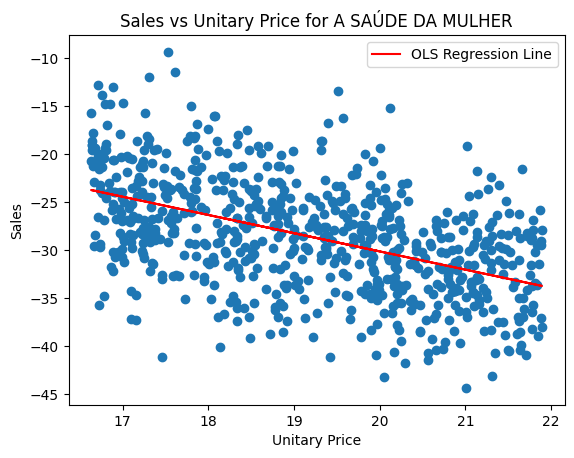

In [74]:

# Define the parameters for the linear relationship
slope = -2
intercept = 10
error_std = 5
df_saude_mulher = df_train[df_train['PRODUTO'] == 'A SAÚDE DA MULHER']
# Generate the QUANTITY_SOLD values
df_saude_mulher['QUANTITY_SOLD'] = intercept + slope * df_saude_mulher['UNITARY_PRICE'] + np.random.normal(0, error_std, len(df_saude_mulher))


len(df_saude_mulher)

plt.scatter(df_saude_mulher['UNITARY_PRICE'], df_saude_mulher['QUANTITY_SOLD'])
plt.xlabel('Unitary Price')
plt.ylabel('Sales')
plt.title('Sales vs Unitary Price for A SAÚDE DA MULHER')
model = sm.OLS(df_saude_mulher['QUANTITY_SOLD'], sm.add_constant(df_saude_mulher['UNITARY_PRICE'])).fit()

# Predict the values
df_saude_mulher['PREDICTED_SALES'] = model.predict(sm.add_constant(df_saude_mulher['UNITARY_PRICE']))

# Plot the regression line
plt.plot(df_saude_mulher['UNITARY_PRICE'], df_saude_mulher['PREDICTED_SALES'], color='red', label='OLS Regression Line')
plt.legend()


In [152]:
# Generate a slope for each unique product in order of appearance
product_slopes = pd.Series(
    np.random.uniform(-1.5, -0.1, size=df_train['PRODUTO'].nunique()),
    index=df_train['PRODUTO'].unique()
)

# Generate noise for each product group (aligned with original DataFrame)
noise = df_train.groupby('PRODUTO', sort=False)['PRODUTO'].transform(
    lambda x: np.random.normal(60, 3, len(x))
)

# Vectorized computation of QUANTITY_SOLD with non-negativity constraint
df_train['QUANTITY_SOLD'] = np.maximum(
    0,  # Ensure quantity sold is at least 0
    intercept 
    + df_train['PRODUTO'].map(product_slopes) * df_train['UNITARY_PRICE'] 
    + noise
)

In [ ]:
#Choose one product, for example, 'BAYCUTEN N'

product_name = 'A SAÚDE DA MULHER'
df_product = df_train[df_train['PRODUTO'] == product_name]

# Fit an OLS model
model = sm.OLS(df_product['QUANTITY_SOLD'], sm.add_constant(df_product['UNITARY_PRICE'])).fit()

# Predict the values
df_product['PREDICTED_SALES'] = model.predict(sm.add_constant(df_product['UNITARY_PRICE']))

# Plot the scatterplot with the regression line
plt.figure(figsize=(10, 6))
plt.scatter(df_product['UNITARY_PRICE'], df_product['QUANTITY_SOLD'], label='Actual Sales')
plt.plot(df_product['UNITARY_PRICE'], df_product['PREDICTED_SALES'], color='red', label='OLS Regression Line')
plt.xlabel('Unitary Price')
plt.ylabel('Sales')
plt.title(f'Sales vs Unitary Price for {product_name}')
plt.legend()
plt.show()

: 

In [161]:
#df_train[df_train['QUANTITY_SOLD'] > 0 ]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15820302 entries, 0 to 15820301
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   PRODUTO             object 
 1   DATE                object 
 2   CLASSE TERAPÊUTICA  object 
 3   LABORATÓRIO         object 
 4   TARJA               object 
 5   PMC Sem Imposto     float64
 6   PMC 0%              float64
 7   PMC 12%             float64
 8   PMC 18%             float64
 9   PMC 21%             float64
 10  PMC 22%             float64
 11  QUANTITY_SOLD       float64
 12  UNITARY_PRICE       float64
 13  year                int32  
 14  month               int32  
 15  day                 int32  
dtypes: float64(8), int32(3), object(5)
memory usage: 1.7+ GB


In [ ]:
df_saude_mulher["QUANTITY_SOLD"] = np.random.exponential(1, size=len(df_saude_mulher))  # Random quantity with mean 1

/tmp/ipykernel_1693810/879414664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_saude_mulher["QUANTITY_SOLD"] = np.random.exponential(1, size=len(df_saude_mulher))  # Random quantity with mean 1


In [157]:
df_product

,PRODUTO,DATE,CLASSE TERAPÊUTICA,LABORATÓRIO,TARJA,PMC Sem Imposto,PMC 0%,PMC 12%,PMC 18%,PMC 21%,PMC 22%,QUANTITY_SOLD,UNITARY_PRICE,year,month,day,PREDICTED_SALES
15698225,AAS PROTECT,2023-01-01,"B1C1 - INIBIDORES DA AGREGAÇÃO PLAQUETÁRIA, CI...",COSMED INDUSTRIA DE COSMETICOS E MEDICAMENTOS ...,Tarja Vermelha,17.12,18.61,21.41,23.16,24.15,24.49,53.961114,19.736569,2023,1,1,49.543442
15698226,AAS PROTECT,2023-01-01,"B1C1 - INIBIDORES DA AGREGAÇÃO PLAQUETÁRIA, CI...",SANOFI MEDLEY FARMACÊUTICA LTDA.,Tarja Vermelha,17.12,18.61,21.41,23.16,24.15,24.49,48.682154,19.318886,2023,1,1,49.972564
15698227,AAS PROTECT,2023-01-02,"B1C1 - INIBIDORES DA AGREGAÇÃO PLAQUETÁRIA, CI...",COSMED INDUSTRIA DE COSMETICOS E MEDICAMENTOS ...,Tarja Vermelha,17.12,18.61,21.41,23.16,24.15,24.49,46.853261,21.014881,2023,1,2,48.230122
15698228,AAS PROTECT,2023-01-02,"B1C1 - INIBIDORES DA AGREGAÇÃO PLAQUETÁRIA, CI...",SANOFI MEDLEY FARMACÊUTICA LTDA.,Tarja Vermelha,17.12,18.61,21.41,23.16,24.15,24.49,48.757020,23.869965,2023,1,2,45.296847
15698229,AAS PROTECT,2023-01-03,"B1C1 - INIBIDORES DA AGREGAÇÃO PLAQUETÁRIA, CI...",COSMED INDUSTRIA DE COSMETICOS E MEDICAMENTOS ...,Tarja Vermelha,17.12,18.61,21.41,23.16,24.15,24.49,47.101453,21.669506,2023,1,3,47.557569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15699682,AAS PROTECT,2024-12-29,"B1C1 - INIBIDORES DA AGREGAÇÃO PLAQUETÁRIA, CI...",SANOFI MEDLEY FARMACÊUTICA LTDA.,Tarja Vermelha,17.12,18.61,21.41,23.16,24.15,24.49,54.299837,20.234447,2024,12,29,49.031929
15699683,AAS PROTECT,2024-12-30,"B1C1 - INIBIDORES DA AGREGAÇÃO PLAQUETÁRIA, CI...",COSMED INDUSTRIA DE COSMETICOS E MEDICAMENTOS ...,Tarja Vermelha,17.12,18.61,21.41,23.16,24.15,24.49,45.957746,23.316974,2024,12,30,45.864982
15699684,AAS PROTECT,2024-12-30,"B1C1 - INIBIDORES DA AGREGAÇÃO PLAQUETÁRIA, CI...",SANOFI MEDLEY FARMACÊUTICA LTDA.,Tarja Vermelha,17.12,18.61,21.41,23.16,24.15,24.49,50.354042,23.598153,2024,12,30,45.576103
15699685,AAS PROTECT,2024-12-31,"B1C1 - INIBIDORES DA AGREGAÇÃO PLAQUETÁRIA, CI...",COSMED INDUSTRIA DE COSMETICOS E MEDICAMENTOS ...,Tarja Vermelha,17.12,18.61,21.41,23.16,24.15,24.49,52.803492,22.637841,2024,12,31,46.562715


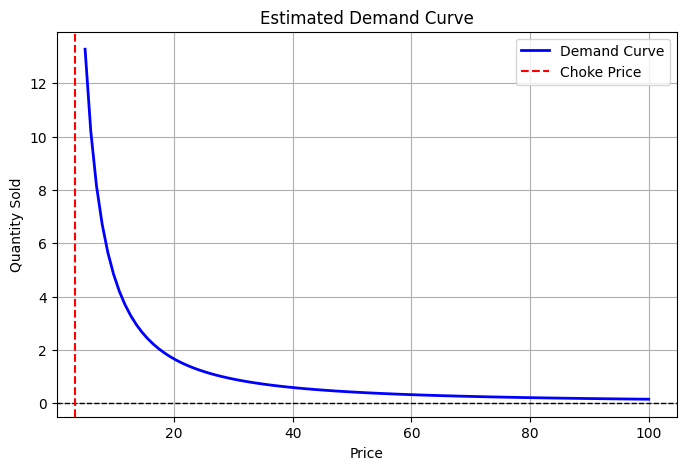

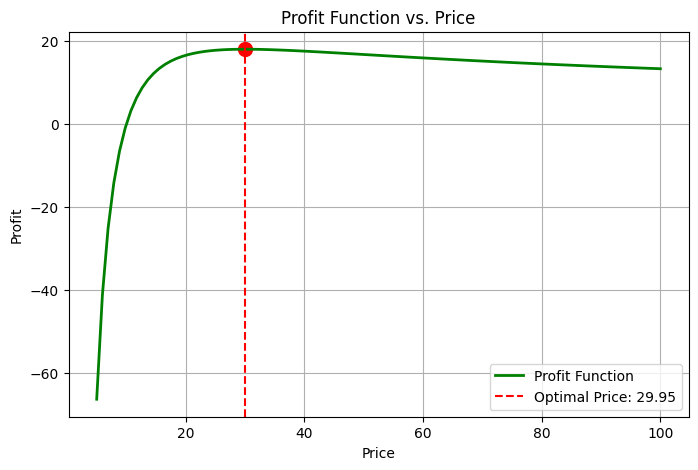

In [164]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated elasticity and intercept (from a model fit)
alpha = 5   # Intercept (log scale)
beta = -1.5 # Elasticity (negative slope)

# Generate price range
prices = np.linspace(5, 100, 100)  # Price range from 5 to 100

# Compute estimated demand
demand = np.exp(alpha + beta * np.log(prices))

# Plot the demand curve
plt.figure(figsize=(8, 5))
plt.plot(prices, demand, label="Demand Curve", color="blue", linewidth=2)

# Labels and title
plt.xlabel("Price")
plt.ylabel("Quantity Sold")
plt.title("Estimated Demand Curve")
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Zero demand line
plt.axvline(-alpha/beta, color='red', linestyle='--', label="Choke Price")  # When Q = 0
plt.legend()
plt.grid()

# Show the plot
plt.show()
import matplotlib.pyplot as plt
import numpy as np

# Simulated parameters (from an estimated model)
alpha = 5    # Intercept (log scale)
beta = -1.5  # Price elasticity
MC = 10      # Assumed marginal cost

# Generate a range of prices
prices = np.linspace(5, 100, 100)  # Price range from 5 to 100

# Compute demand function Q(P)
demand = np.exp(alpha + beta * np.log(prices))

# Compute profit function: Profit(P) = (P - MC) * Q(P)
profit = (prices - MC) * demand

# Find the optimal price where profit is maximized
optimal_price = prices[np.argmax(profit)]
max_profit = max(profit)

# Plot the profit function
plt.figure(figsize=(8, 5))
plt.plot(prices, profit, label="Profit Function", color="green", linewidth=2)

# Mark the optimal price
plt.axvline(optimal_price, color="red", linestyle="--", label=f"Optimal Price: {optimal_price:.2f}")
plt.scatter(optimal_price, max_profit, color="red", s=100)

# Labels and title
plt.xlabel("Price")
plt.ylabel("Profit")
plt.title("Profit Function vs. Price")
plt.legend()
plt.grid()

# Show the plot
plt.show()
